<h2> Dieses Notebook führt die Volumenschätzung ausschließlich aus Basis der Tiefenwerte, intrinsischen Matrix und referenz Dimensionen aus, welche direkt aus dem IPhone via Apple SDK gewonnen wurden.

# Import der Libraries

In [100]:
from PIL import Image, ImageOps, ImageFilter
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
import cv2
import glob
from Functions.binary_dm import transform_binary_to_depthmap


# Tiefenkarte lesen und plotten

Einlesen der Binary

In [101]:
binary_url = r"C:\Users\Diren\Nextcloud\HTW\4.Semester-Masterarbeit\Masterarbeit\Code\XCodeDirectExtraction\LidarData\Karton\DepthMap.bin"
depth_map = transform_binary_to_depthmap(binary_url)

In [102]:
print(depth_map.dtype)


float16


Einlesen des RGB image

In [103]:
rgb_url = r"C:\Users\Diren\Nextcloud\HTW\4.Semester-Masterarbeit\Masterarbeit\Code\XCodeDirectExtraction\LidarData\color_image.jpg"
rgb_im = Image.open(rgb_url)

In [104]:
rgb_height, rgb_width =rgb_im.size
rgb_height

1920

Plotten der Tiefenkarte

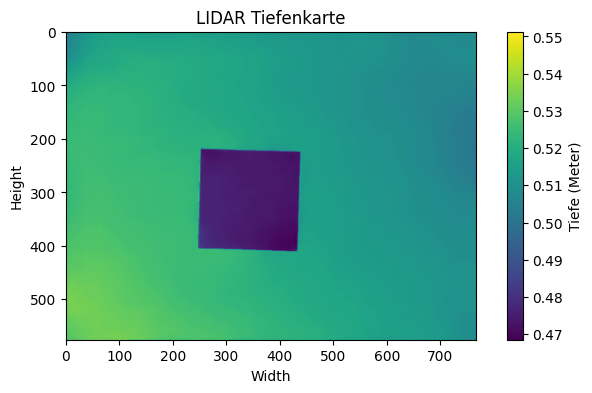

In [105]:
plt.figure(figsize=(8, 4))
plt.imshow(depth_map, cmap = "viridis")
plt.colorbar(label="Tiefe (Meter)")
plt.title("LIDAR Tiefenkarte")
plt.ylabel("Height")
plt.xlabel("Width")
plt.show()


In [106]:
depth_map.size

442368

We need to resize the rgb image later to this size to combine depth map and RGB image and create a RGBD image. First we get the size of the depth map and then resize the RGB image to that size.

In [107]:
def resize(rgb_im, depth_im):
    rgb_width, rgb_height = rgb_im.size
    rgb_width_original, rgb_height_original = rgb_im.size #need that for later use
    dm_width, dm_height = depth_im.size  # width and height of depth map image. 
    
    print(f"dm_height:{dm_height}, dm_width:{dm_width}\n rgb_height:{rgb_height}, rgb_width:{rgb_width}")  # need to scale our RGB image to the size of our depthmap image
    
    size = (dm_width, dm_height)  # define new size
    rgb_im = rgb_im.resize(size)  # fitting the rgb image size to the size of the depth image
    
    rgb_width, rgb_height = rgb_im.size
    print(f"new_rgb_height:{rgb_height}, new_rgb_width:{rgb_width}")
    
    return rgb_im, dm_width, dm_height, rgb_width_original, rgb_height_original

# Exiftool camera calibration

In [108]:
dm_height, dm_width= depth_map.shape
dm_height

576

intrinsische Matrix

In [109]:
intrinsic_matrix = np.array([
    [2943.626708984375, 0, 2006.96923828125],
    [0, 2943.626708984375, 1519.7119140625],
    [0, 0, 1]
])

print(intrinsic_matrix)


[[2.94362671e+03 0.00000000e+00 2.00696924e+03]
 [0.00000000e+00 2.94362671e+03 1.51971191e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


Referenzdimensionen für die Skalierung der intrinsischen Matrix

In [110]:
#OriginalWerte
# ref_height = 4032
# ref_width = 3024

In [111]:
#Diese Werte nutze ich zum testen, da die Tiefekarte gekippt ist, sind auch höhe und breite vertauscht
ref_height = 3024
ref_width = 4032

In [112]:
# sclaingfactor
scale_x = dm_width / ref_width
scale_y = dm_height / ref_height

# scaling
scaled_mtx = intrinsic_matrix.copy()
scaled_mtx[0, 0] *= scale_x  # f_x
scaled_mtx[1, 1] *= scale_y  # f_y
scaled_mtx[0, 2] *= scale_x  # c_x
scaled_mtx[1, 2] *= scale_y  # c_y

print("Angepasste intrinsische Matrix:")
print(scaled_mtx)

Angepasste intrinsische Matrix:
[[560.69080171   0.         382.27985491]
 [  0.         560.69080171 289.46893601]
 [  0.           0.           1.        ]]


because the depthmap is already processes by the IPhone and normalized, I have to scale to numbers back to meters. the maximum depth captured by the LIDAR sensor seems to be 5 meters.
so the maximum value of the unedited array, which is 255, is equal to 5 meters while 0 = 0 meters.

scaled intrinsic

In [113]:
fx = scaled_mtx[0, 0]
fy = scaled_mtx[1, 1]
cx = scaled_mtx[0, 2]
cy = scaled_mtx[1, 2]

print(f"fx: {fx}, fy: {fy}, cx: {cx}, cy: {cy}")


# Intrinsic Matrix als Open3D-Objekt
intrinsic_scaled = o3d.camera.PinholeCameraIntrinsic(width=dm_width, height=dm_height, fx=fx, fy=fy, cx=cx, cy=cy)


fx: 560.6908017113095, fy: 560.6908017113095, cx: 382.2798549107143, cy: 289.46893601190476


# Create point cloud

Open3D Object without metric scaling

In [114]:
depth_data_uint16_Iphone = (depth_map.astype(np.uint16)) #Quelle: https://stackoverflow.com/questions/73067231/how-to-convert-uint8-image-to-uint16-python
depth_uint16_o3d_Iphone = o3d.geometry.Image(depth_data_uint16_Iphone)

# Open3D-Image aus Tiefenkarte erstellen
depth_image = o3d.geometry.Image(depth_uint16_o3d_Iphone)

In [115]:
depth_image = o3d.geometry.Image(depth_map.astype(np.float32))

Pointcloud

In [116]:
pcd = o3d.geometry.PointCloud.create_from_depth_image(
    depth_image,
    intrinsic_scaled,
    depth_scale=1.0,  # 
    depth_trunc=3.0,  # Maximal erlaubte Tiefe. 3 Meter reichen für unsere Ansprüche.
    stride=1  # Jeder Pixel wird genutztbei Stride = 1
)


In [117]:
num_points = len(np.asarray(pcd.points))
print(f"Anzahl der Punkte in der Punktwolke: {num_points}")

Anzahl der Punkte in der Punktwolke: 442368


# Clean Point Cloud

## Estimating normals

In [118]:
nn_distance = np.mean(pcd.compute_nearest_neighbor_distance())

print(nn_distance)

0.0009073710400173358


In [119]:
radius_normals = nn_distance * 4

pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normals, max_nn=16), fast_normal_computation=True)

pcd.paint_uniform_color([0.6, 0.6, 0.6])
#o3d.visualization.draw_geometries([pcd])

PointCloud with 442368 points.

To get better results from the PC for the volume estimation I will clean it using Open3D methods

In [120]:
pcd_center = pcd.get_center()
pcd.translate(pcd_center)

PointCloud with 442368 points.

## Plane segmentation with RANSAC

In [121]:
plane_model, inliers = pcd.segment_plane(
    distance_threshold=0.009,
    ransac_n=10,
    num_iterations=6000,
    probability=1
)

[a, b, c, d] = plane_model.tolist()

# Inlier- und Outlier-Punktwolken
pcd_plane = pcd.select_by_index(inliers)
inlier_cloud = pcd_plane.paint_uniform_color([1.0, 0, 0])
outlier_cloud = pcd.select_by_index(inliers, invert=True)

# Darstellung der Punktwolken
#o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])


In [122]:
o3d.visualization.draw_geometries([outlier_cloud])

In [123]:
pcd_object = outlier_cloud

## Statistical oulier removal (SOR)
Bereinigung der Punktwolke mit Statistical Outlier Removal

In [124]:
#Quelle: https://www.open3d.org/docs/latest/tutorial/Advanced/pointcloud_outlier_removal.html

def display_inlier_outlier(cloud, ind):
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])

Removing the outliers

In [125]:
cl, ind = pcd_object.remove_statistical_outlier(nb_neighbors=400, std_ratio=1.0) #gute Ergebnisse mit diesen Werten bisher

Displaying inlier in grey and outlier in red

In [126]:
import psutil
print(f"RAM-Auslastung: {psutil.virtual_memory().percent}%")


RAM-Auslastung: 51.5%


In [127]:
display_inlier_outlier(pcd_object, ind)

Showing outliers (red) and inliers (gray): 


We will use this PC from now on

In [128]:
# Cleaned PC
pcd_object = pcd_object.select_by_index(ind)  # Nur Inlier

Clean Plane too 

In [129]:
cl, ind = pcd_plane.remove_statistical_outlier(nb_neighbors=100, std_ratio=1.2) #gute Ergebnisse mit diesen Werten bisher

In [130]:
# Cleaned PC
pcd_plane = pcd_plane.select_by_index(ind)  # Nur Inlier

In [131]:
plane_array = np.asarray(pcd_plane.points, dtype=np.float16)

In [132]:
#o3d.visualization.draw_geometries([pcd_plane], window_name="RANSAC Plane") 

Visualizing the new PC of the object

In [133]:
pcd_object_array = np.asarray(pcd_object.points, dtype=np.float16)

In [134]:
print(pcd_object_array.dtype)

float16


## Punktwolke berichtigen

Das Problem beim Extrahieren des jeweiligen Lebensmittels ist, dass, da nicht alle Punkte in der Tiefenkarte sichtbar sind, diese Punkte fehlen und das Objekt an Höhe verliert, sobald man den RANSAC-Algorithmus ausführt.
Um die korrekte Höhe beizubehalten, kann man das Lebensmittel bis zur ebenen Fläche erweitern und somit vervollständigen.  

Wir benötigen die untersten Punkte der Objekt-Punktwolke

In [135]:
# Maximalen z-Wert des Objekts bestimmen
max_z_object = max(pcd_object_array[:, 2].tolist())  # Nutzt weniger RAM als np.max()
print(f"Tiefster z-Wert des Objekts: {max_z_object}")

Tiefster z-Wert des Objekts: 1.0146484375


In [136]:
# Durchschnitt
avg_z_plane = plane_array[:, 2].mean()
print(f"Durchschnittliche Tiefe der Ebene: {avg_z_plane}")

Durchschnittliche Tiefe der Ebene: 1.03125


In [137]:
# Minimalen z-Wert der Ebene bestimmen
max_z_plane = plane_array[:, 2].max()
print(f"Tiefster z-Wert der Ebene: {max_z_plane}")

Tiefster z-Wert der Ebene: 1.048828125


In [138]:
# Threshold für die Bestimmung der unteren Punkte des Objekts
threshold = 0.005

# 1. Tiefste Punkte des Objekts erhalten
bottom_edge = []

for row in pcd_object_array:
    if abs(row[2] - max_z_object) < threshold:  
        bottom_edge.append(row.tolist())  # "tolist()" konvertiert die numpy-Row in eine Liste für bessere Performance

bottom_edge = np.array(bottom_edge)  # Am Ende in ein numpy-Array umwandeln


# 3. Punktwolke in Open3D erstellen
bottom_edge_pcd = o3d.geometry.PointCloud()
bottom_edge_pcd.points = o3d.utility.Vector3dVector(bottom_edge)


In [140]:
o3d.visualization.draw_geometries([bottom_edge_pcd])

In [40]:
bottom_edge

array([[-1.49383545e-02, -5.49011230e-02,  1.02734375e+00],
       [-1.39999390e-02, -5.48095703e-02,  1.02636719e+00],
       [-1.29413605e-03, -5.47485352e-02,  1.02636719e+00],
       [-3.88145447e-04, -5.48095703e-02,  1.02636719e+00],
       [ 5.18798828e-04, -5.49011230e-02,  1.02734375e+00],
       [-1.76544189e-02, -5.39550781e-02,  1.02734375e+00],
       [ 4.15039062e-03, -5.39550781e-02,  1.02734375e+00],
       [-2.13165283e-02, -5.31311035e-02,  1.02832031e+00],
       [ 8.70513916e-03, -5.31311035e-02,  1.02832031e+00],
       [-2.30712891e-02, -5.20935059e-02,  1.02636719e+00],
       [ 1.05209351e-02, -5.21850586e-02,  1.02734375e+00],
       [ 1.23062134e-02, -5.11169434e-02,  1.02636719e+00],
       [-2.68096924e-02, -5.04455566e-02,  1.02832031e+00],
       [ 1.41677856e-02, -5.04150391e-02,  1.02832031e+00],
       [-2.75878906e-02, -4.93164062e-02,  1.02636719e+00],
       [-2.94799805e-02, -4.85534668e-02,  1.02734375e+00],
       [-3.03344727e-02, -4.75463867e-02

In [40]:
# 4. Punkte in Z-Richtung erweitern

new_points = []
for x, y, z in bottom_edge:
    # Falls der Punkt zu tief liegt, berechne eine Korrektur
    if z < avg_z_plane:
        z = z + (avg_z_plane - z) * 0.5  # Hebe ihn nur halb an

    current_z = z
    while current_z < avg_z_plane:
        current_z += 0.0015
        if current_z > avg_z_plane:
            break
        new_points.append([x, y, current_z])


# 5. Neue Punkte zur Open3D Punktwolke hinzufügen
new_points = np.array(new_points)  # Am Ende in ein numpy-Array umwandeln

# 6. Ausgabe
print(f"Anzahl ursprünglicher Punkte: {len(bottom_edge)}")
print(f"Anzahl neuer Punkte: {len(new_points)}")
print(f"Gesamtanzahl Punkte in der Punktwolke: {len(pcd.points)}")

# 7. Punktwolke der neuen Punkte visualisieren

new_points_pcd = o3d.geometry.PointCloud()
new_points_pcd.points = o3d.utility.Vector3dVector(new_points)

o3d.visualization.draw_geometries([new_points_pcd])

NameError: name 'bottom_edge' is not defined

In [58]:
o3d.visualization.draw_geometries([new_points_pcd, bottom_edge_pcd])


In [62]:
o3d.visualization.draw_geometries([new_points_pcd, pcd_object])

This code extends all the points of the object and thus creates a filled object. 

In [88]:
# 4. Punkte in Z-Richtung erweitern

new_points_dos = []
for x, y, z in pcd_object_array:
    # Falls der Punkt zu tief liegt, berechne eine Korrektur
    
    current_z = z
    while current_z < avg_z_plane:
        current_z += 0.0015
        if current_z > avg_z_plane:
            break
        new_points_dos.append([x, y, current_z])


# 5. Neue Punkte zur Open3D Punktwolke hinzufügen
new_points_dos = np.array(new_points_dos)  # Am Ende in ein numpy-Array umwandeln

# 7. Punktwolke der neuen Punkte visualisieren

new_points_pcd_dos = o3d.geometry.PointCloud()
new_points_pcd_dos.points = o3d.utility.Vector3dVector(new_points_dos)

o3d.visualization.draw_geometries([new_points_pcd_dos])

In [42]:
o3d.visualization.draw_geometries([new_points_pcd_dos, pcd_plane])

Punkte generieren Quelle: https://stackoverflow.com/questions/65774814/adding-new-points-to-point-cloud-in-real-time-open3d

In [1]:
# # Punktwolke in Open3D-Format umwandeln
# new_pcd = o3d.geometry.PointCloud()
# new_pcd.points = o3d.utility.Vector3dVector(bottom_edge)  # NumPy → Open3D
# 
# # Punktwolke anzeigen
# o3d.visualization.draw_geometries([new_pcd])

# Zusammenfassung der Punktwolke

## Ausdehnung des Objekts

In [89]:
bounds = new_points_pcd_dos.get_max_bound() - new_points_pcd_dos.get_min_bound()
print(f"Ausdehnung der Punktwolke: x={bounds[0]:.3f}, y={bounds[1]:.3f}, z={bounds[2]:.3f}")

Ausdehnung der Punktwolke: x=0.169, y=0.167, z=0.047


# Volumenberechnung

## Voxelization

Sehr wichtig!: Wenn wir statt einfach nur die border zu erweitern und mit der ursprünglichen PCD des Objekts verbinden, die ursprüngliche PCD (ist ja eine Hülle) erweitern und so ein ausgefülltes Objekt erhalten und dieses dann nutzen, um mit Voxelization das Volumen zu erhalten, dann ist das Ergebnis viel besser. Das 

In [96]:
# Voxelgröße (anpassen je nach Detailgrad)
voxel_size = 0.0008  # 1,3mm pro Voxel ist gut. ggf. kann ich ein algorithmus schrieben der die "perfekte" size findet in dem dieser selbst den wert nach oben oder unten justiert

# Voxelgrid aus der Punktwolke erstellen
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(new_points_pcd_dos, voxel_size=voxel_size)

# Berechne das Volumen
voxel_volumen = len(voxel_grid.get_voxels()) * (voxel_size ** 3)

print(f"Geschätztes Volumen der Punktwolke: {voxel_volumen:.6f} m³")

# **Visualisierung der Voxel**
o3d.visualization.draw_geometries([voxel_grid])

Geschätztes Volumen der Punktwolke: 0.000493 m³


In [55]:
print('input')
N = 2000

# fit to unit cube
new_points_pcd.scale(1 / np.max(pcd.get_max_bound() - pcd.get_min_bound()),
          center=pcd.get_center())
pcd.colors = o3d.utility.Vector3dVector(np.random.uniform(0, 1, size=(N, 3)))
o3d.visualization.draw_geometries([pcd])

print('voxelization')
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(new_points_pcd,
                                                            voxel_size=0.05)
o3d.visualization.draw_geometries([voxel_grid])



input
voxelization


## Convex Hull

In [91]:
# calculate hull
hull_mesh, hull_vertices = new_points_pcd_dos.compute_convex_hull()

hull_ls = o3d.geometry.LineSet.create_from_triangle_mesh(hull_mesh)

hull_ls.paint_uniform_color([1, 0, 0])

o3d.visualization.draw_geometries([new_points_pcd_dos, hull_ls])

volume = hull_mesh.get_volume()


In [92]:
volume_ml = volume * 1_000_000  # Umrechnung von m³ in ml
print(f"Volumen: {volume_ml:.2f} ml")

Volumen: 1162.06 ml


## Bounding Box

In [45]:
import open3d as o3d
import numpy as np


# Axis-Aligned Bounding Box (AABB) berechnen und visualisieren
aabb = new_points_pcd_dos.get_axis_aligned_bounding_box()
aabb.color = (1, 0, 0)  # Rot

# Oriented Bounding Box (OBB) berechnen
oriented_bb = new_points_pcd_dos.get_oriented_bounding_box()
oriented_bb.color = (0, 1, 0)  # Grün

# Bounding-Boxen und Punktwolke visualisieren
o3d.visualization.draw_geometries([new_points_pcd_dos, aabb, oriented_bb])

# Volumenberechnung der OBB
obb_extents = oriented_bb.extent
obb_volume = obb_extents[0] * obb_extents[1] * obb_extents[2]

print(f"Volumen der Oriented Bounding Box (OBB): {obb_volume:.2f}")

#Debugging: Bounding-Box-Größe prüfen
min_bound = new_points_pcd_dos.get_min_bound()
max_bound = new_points_pcd_dos.get_max_bound()
print(f"Min Bound: {min_bound}, Max Bound: {max_bound}")
print(f"AABB Größe: {aabb.get_extent()}")
print(f"OBB Größe: {obb_extents}")

obb_volume = np.prod(obb_extents)
print(f"Korrigiertes OBB-Volumen: {obb_volume:.6f} m³")


Volumen der Oriented Bounding Box (OBB): 0.00
Min Bound: [-0.09350586 -0.01898193  1.01224219], Max Bound: [0.06292725 0.02940369 1.03610156]
AABB Größe: [0.15643311 0.04838562 0.02385938]
OBB Größe: [0.15628299 0.05054246 0.02866449]
Korrigiertes OBB-Volumen: 0.000226 m³


## Alpha shapes

In [93]:
nn_distance = np.mean(new_points_pcd_dos.compute_nearest_neighbor_distance())

print(nn_distance)
radius_normals = nn_distance * 4

new_points_pcd_dos.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normals, max_nn=16),
                     fast_normal_computation=True)

new_points_pcd_dos.paint_uniform_color([0.6, 0.6, 0.6])
o3d.visualization.draw_geometries([new_points_pcd_dos])

0.0008373595213376322


In [94]:
# Quelle Code: https://www.open3d.org/docs/latest/tutorial/Advanced/surface_reconstruction.html
# Quelle Theorie:  [Edelsbrunner1983] Edelsbrunner and D. G. Kirkpatrick and R. Seidel: On the shape of a set of points in the plane, IEEE Transactions on Information Theory, 29 (4): 551–559, 1983

alpha = 0.6
print(f"alpha={alpha:.3f}")
alpha_shape  = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(new_points_pcd_dos, alpha)
alpha_shape.compute_vertex_normals()
o3d.visualization.draw_geometries([alpha_shape], mesh_show_back_face=True)



alpha=0.400


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh

In [95]:
# Volumenberechnung mit Tetrahedron Decomposition (Delaunay Triangulation)
def compute_mesh_volume(mesh):
    vertices = np.asarray(mesh.vertices)
    triangles = np.asarray(mesh.triangles)
    
    volume = 0.0
    for tri in triangles:
        v0, v1, v2 = vertices[tri[0]], vertices[tri[1]], vertices[tri[2]]
        tetra_volume = np.dot(v0, np.cross(v1, v2)) / 6.0  # Volumen eines Tetraeders
        volume += tetra_volume
    
    return abs(volume)

# Volumen berechnen
volumen = compute_mesh_volume(alpha_shape)
print(f"Volumen des Alpha Shapes: {volumen:.5f} m³")


Volumen des Alpha Shapes: 0.00079 m³


## Delauney

In [97]:
mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(new_points_pcd_dos, depth=9)

In [98]:
o3d.visualization.draw_geometries([mesh], window_name="Poisson Mesh")

#  Test

In [99]:
# Punktwolke laden

# Normale berechnen (wichtig für Poisson!)
new_points_pcd_dos.estimate_normals()

# Poisson-Rekonstruktion
mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(new_points_pcd_dos, depth=9)

# Punktwolke aus Mesh extrahieren
pcd_dense = mesh.sample_points_uniformly(number_of_points=500000)  # Anzahl erhöhen für mehr Dichte

# Visualisieren
o3d.visualization.draw_geometries([pcd_dense])
